In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

In [2]:
import tqdm

In [3]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import phenom

import lal
import lalsimulation as lalsim

from scrinet.interfaces import lalutils

In [4]:
from scrinet.greedy import greedyrb
from scrinet.surrogate import surrogate

In [5]:
import copy

# Data acquisition

We need a function that we can call to
generate data in a uniform way.

We will use this to generate the data for:
 - the seed basis
 - additional training sets and
 - validation sets

In [7]:
def gen_2d_massratio_chi_data(q_array, chi_array, M, deltaT=1/1024., f_min=10,
                         approximant=lalsim.SEOBNRv4_opt, inclination=0,
                          t_min=-1000, t_max=100, npts=1000
                         ):


    new_times = np.linspace(t_min, t_max, npts)
    
    data = []
    coords = []
    
    for q, chi in zip(q_array, chi_array):
#         print(q,chi)
        m1, m2 = phenom.m1_m2_M_q(M, q)
        pp = dict(m1=m1, m2=m2, deltaT=deltaT,
                  f_min=f_min,
                  inclination=inclination,
                  S1z=chi, S2z=chi,
                  approximant=approximant
                 )
        p = lalutils.gen_td_wf_params(**pp)
        t, amp, phase = lalutils.gen_td_wf(p, t_min=t_min, t_max=t_max)
              
        iamp = IUS(t, amp)
        iphase = IUS(t, phase)
        
        amp = iamp(new_times)
        phase = iphase(new_times)
        
        tshift = lalutils.peak_align_shift(new_times, amp)
        amp = lalutils.peak_align_interp(new_times, amp, tshift)
        phase = lalutils.peak_align_interp(new_times, phase, tshift)
        
        d = {"t":new_times, "amp":amp, "phase":phase}
        
        data.append(d)
        coords.append([q, chi])
    
    n_t_points = len(new_times)
    n_waveforms = len(data)
    ts_amp = np.zeros(shape=(n_waveforms, n_t_points))
    ts_phase = np.zeros(shape=(n_waveforms, n_t_points))
    
    for i in range(n_waveforms):
        ts_amp[i] = data[i]['amp'] / phenom.eta_from_q(coords[i][0]) / 1e5
        ts_phase[i] = data[i]['phase'] - data[i]['phase'][0]
        
    return new_times, ts_amp, ts_phase, np.array(coords)

In [8]:
mtotal = 100

In [10]:
qmin=1
qmax=4
chimin=-0.6
chimax=0.6

In [11]:
# qq, cc = np.meshgrid(np.linspace(1,10,3), np.linspace(-0.99,0.99,3))
qq, cc = np.meshgrid(np.linspace(qmin, qmax, 3), np.linspace(chimin, chimax, 3))
qq = qq.ravel()
cc = cc.ravel()

In [12]:
seed_x, seed_ts_amp, seed_ts_phase, seed_ts_coords = gen_2d_massratio_chi_data(qq, cc, mtotal) 

In [13]:
seed_ts_amp.shape

(9, 1000)

In [14]:
plt.figure()
for i in range(len(seed_ts_amp)):
#     plt.plot(seed_x, seed_ts_amp[i] / phenom.eta_from_q(seed_ts_coords[i]))
    plt.plot(seed_x, seed_ts_amp[i])
plt.yscale('log')

In [15]:
plt.figure()
for i in range(len(seed_ts_amp)):
#     plt.plot(seed_x, seed_ts_amp[i] / phenom.eta_from_q(seed_ts_coords[i]))
    plt.plot(seed_x, seed_ts_amp[i])
plt.yscale('log')
plt.xlim(-100,110)

(-100, 110)

In [16]:
plt.figure()
for i in range(len(seed_ts_amp)):
    plt.plot(seed_x, seed_ts_phase[i])

# run

In [17]:
# Make integration rule

int_range = [seed_x[0], seed_x[-1]]
int_num = len(seed_x)

integration = greedyrb.Riemann(int_range, num=int_num)
x = integration.nodes  # Define x for convenience

In [18]:
sur = surrogate.Surrogate(integration) 

In [19]:
sur.build_seed_basis(ts=seed_ts_amp, ts_coords=seed_ts_coords) 

building seed basis


In [20]:
sur.grb.greedy_points

array([[ 1. , -0.6],
       [ 2.5, -0.6],
       [ 4. , -0.6],
       [ 1. ,  0. ],
       [ 2.5,  0. ],
       [ 4. ,  0. ],
       [ 1. ,  0.6],
       [ 2.5,  0.6],
       [ 4. ,  0.6]])

In [21]:
sur.grb.greedy_points[:,0]

array([1. , 2.5, 4. , 1. , 2.5, 4. , 1. , 2.5, 4. ])

In [22]:
sur.grb.greedy_points[:,1]

array([-0.6, -0.6, -0.6,  0. ,  0. ,  0. ,  0.6,  0.6,  0.6])

In [23]:
%%time
# check seed basis and add points
_, ts_amp, _, ts_coords = gen_2d_massratio_chi_data(
    np.random.uniform(qmin, qmax, 1000),
    np.random.uniform(chimin, chimax, 1000),
    mtotal)

CPU times: user 51.4 s, sys: 4.86 s, total: 56.3 s
Wall time: 56.3 s


In [24]:
sur.run_greedy_sweep(ts_amp, ts_coords, verbose=True, greedy_tol=1e-8)

step = 0, error = 0.00012527838398553287
step = 1, error = 3.42694456898165e-05
step = 2, error = 4.261673545621611e-06
step = 3, error = 2.0773446890496774e-06
step = 4, error = 7.362282218781225e-07
step = 5, error = 4.868418094873426e-07
step = 6, error = 3.58047088529247e-07
step = 7, error = 1.5439641134641597e-07
step = 8, error = 1.3270898908306306e-07
step = 9, error = 9.432182489998079e-08
step = 10, error = 5.78411550642411e-08
step = 11, error = 3.481039754156405e-08
step = 12, error = 1.852170452737832e-08
step = 13, error = 1.6463638203160212e-08
step = 14, error = 1.4763149039801996e-08
step = 15, error = 1.0425479952897652e-08
tolerance reached. exiting


In [25]:
print(sur.grb.nbasis)

25


In [26]:
# build eim
# eim needs to be built from training_set at the greedy points
_, ts, _, _ = gen_2d_massratio_chi_data(*sur.grb.greedy_points.T, mtotal)

In [27]:
sur.build_eim(ts) 

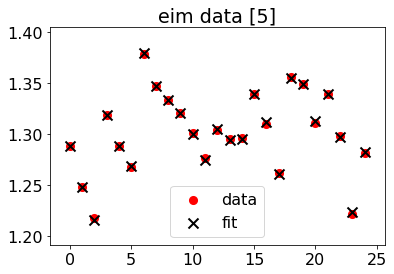

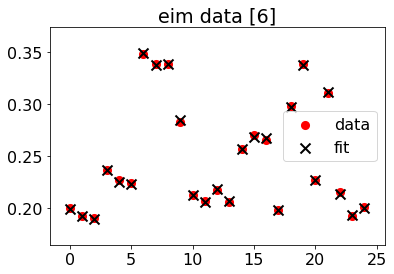

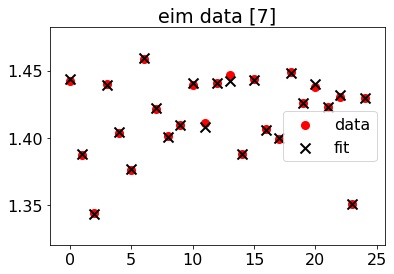

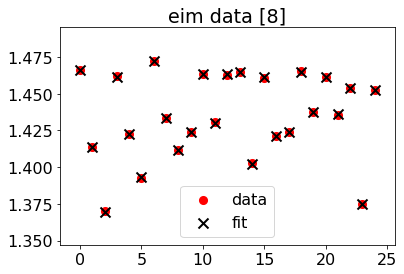

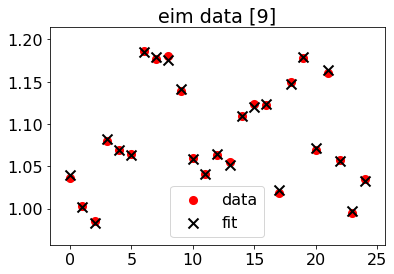

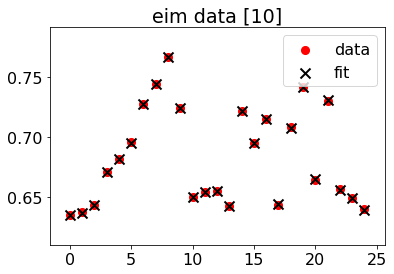

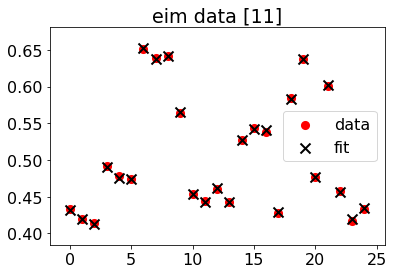

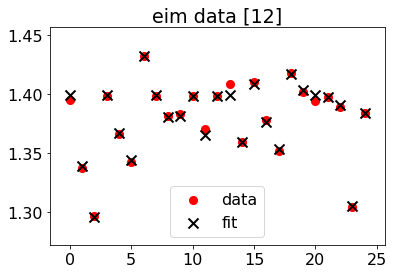

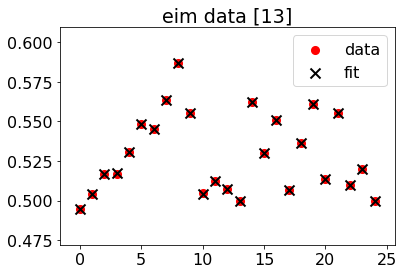

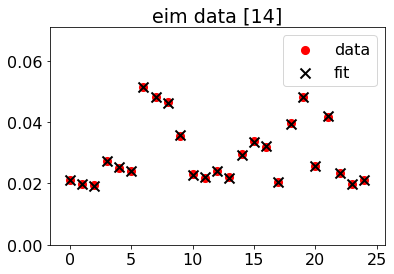

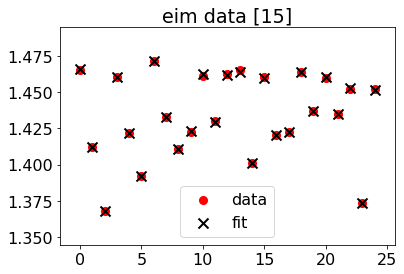

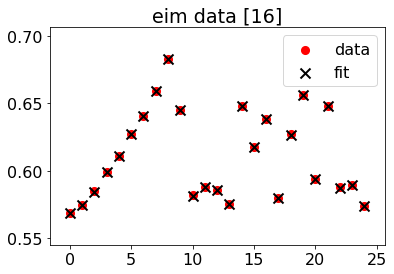

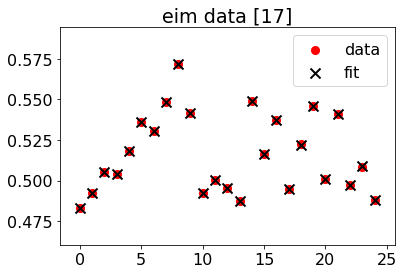

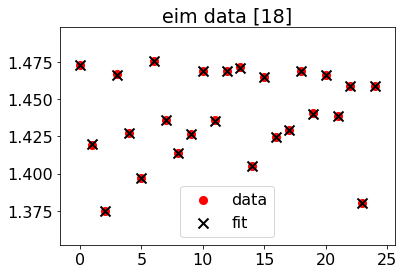

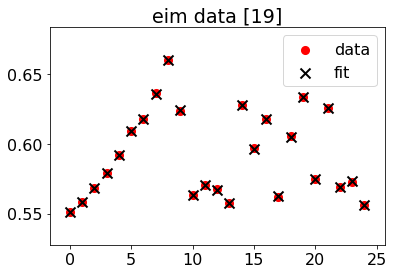

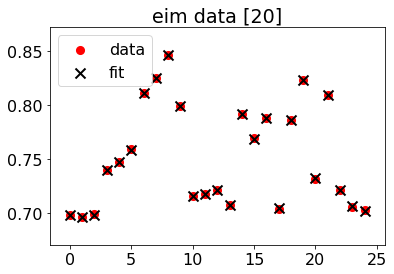

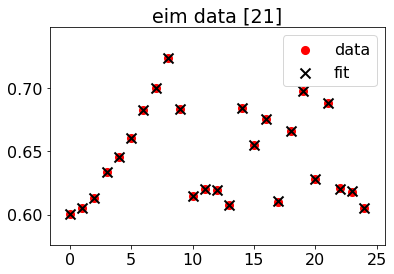

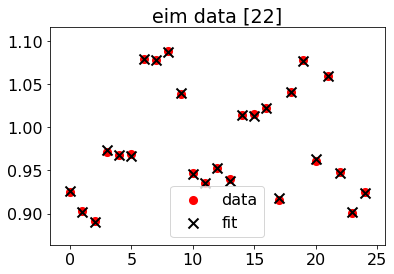

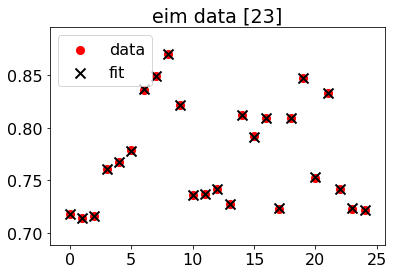

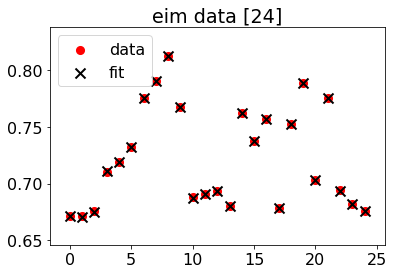

In [28]:
# fit_eim
X = sur.grb.greedy_points.copy()
X[:,0] = np.log(X[:,0])
y = sur.grb.eim.data
sur.fit_eim(X, y, method='lr', maxdegs=[4,4], max_deg_total=4*2)

In [29]:
sur.grb.nbasis

25

In [30]:
_, vts, _, vts_coords = gen_2d_massratio_chi_data(
    np.random.uniform(qmin, qmax, 100),
    np.random.uniform(chimin, chimax, 100),
    mtotal)

In [31]:
model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
print(f"worst case = {worst_case}")

worst case = [ 3.28322229 -0.43296429]


In [32]:
%%timeit
sur.predict([worst_case])

2.54 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


(-500, 100)

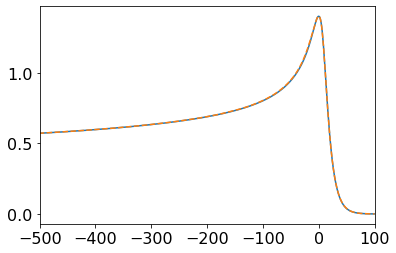

In [33]:
plt.figure()
plt.plot(seed_x, vts[worst_error_index])
plt.plot(seed_x, sur.predict([worst_case]), ls='--')
plt.xlim(-500,100)

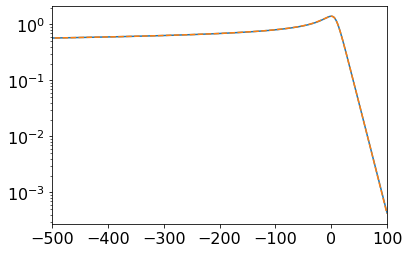

In [34]:
plt.figure()
plt.plot(seed_x, vts[worst_error_index])
plt.plot(seed_x, sur.predict([worst_case]), ls='--')
plt.xlim(-500,100)
plt.yscale('log')

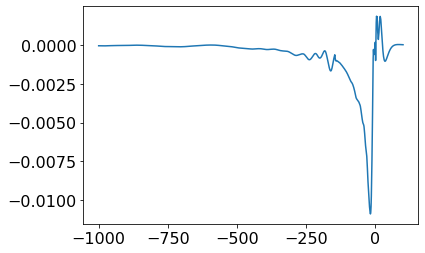

In [35]:
plt.figure()
plt.plot(seed_x, vts[worst_error_index] - sur.predict([worst_case]))

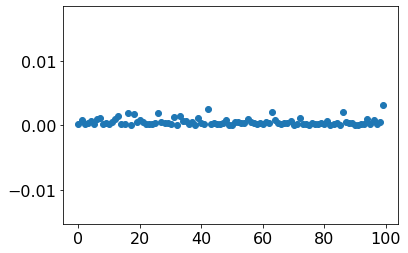

In [36]:
plt.figure()
plt.scatter(range(len(model_errors)), model_errors)
# plt.scatter(range(len(sur.grb.greedy_points)), np.zeros(len(sur.grb.greedy_points)))
plt.show()
plt.close()

In [37]:
vts_worst = vts[worst_error_index]
vts_coords_worst = vts_coords[worst_error_index]

In [38]:
vts_coords_worst

array([ 3.28322229, -0.43296429])

In [39]:
# add the worst case to the basis and re-fit
sur.run_greedy_sweep(vts_worst.reshape(1,-1), vts_coords_worst.reshape(1, -1), greedy_tol=1e-12)

step = 0, error = 2.2400622523007922e-09


In [40]:
sur.grb.nbasis 

26

In [41]:
# build eim
# eim needs to be built from training_set at the greedy points
_, ts, _, _ = gen_2d_massratio_chi_data(*sur.grb.greedy_points.T, mtotal)

In [42]:
sur.build_eim(ts)

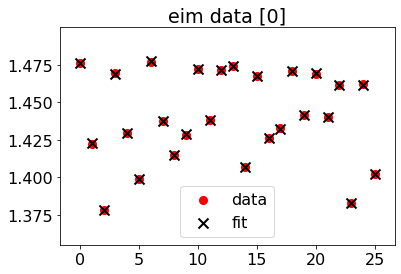

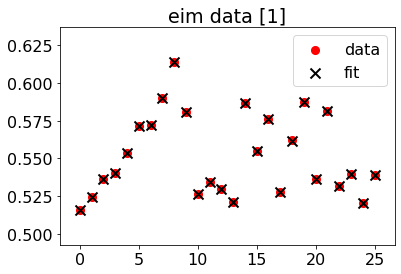

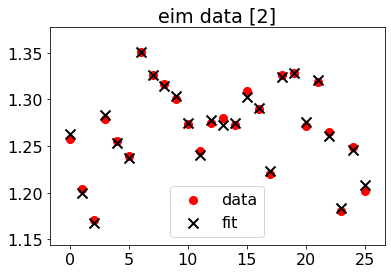

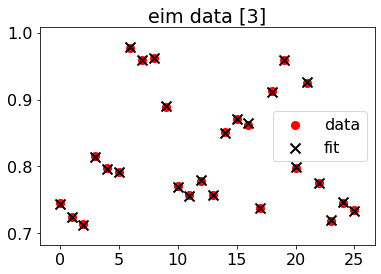

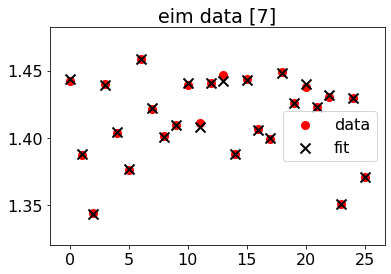

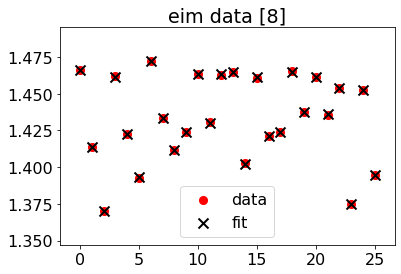

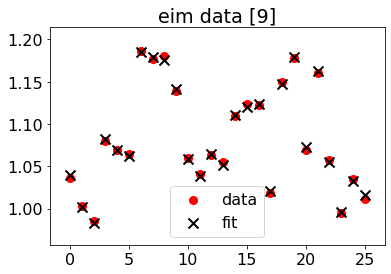

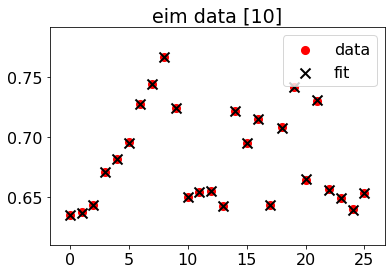

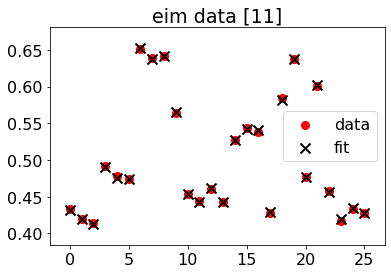

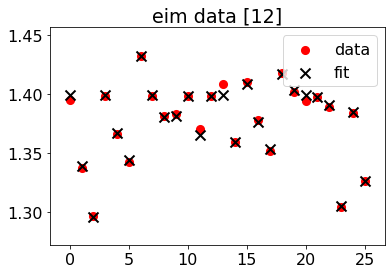

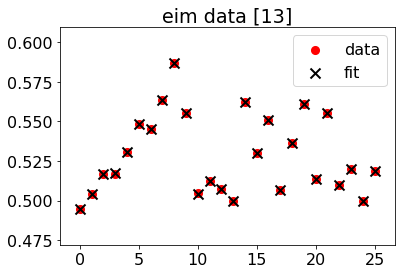

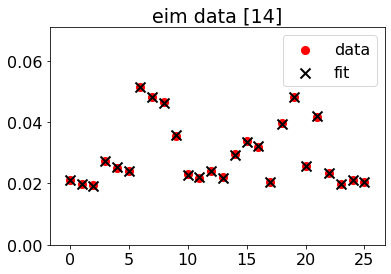

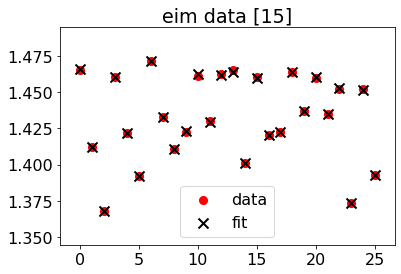

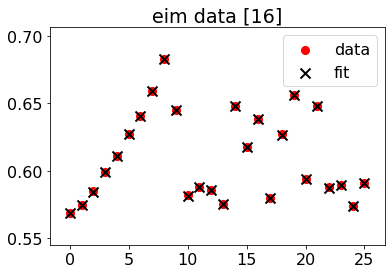

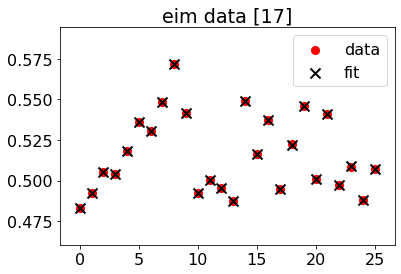

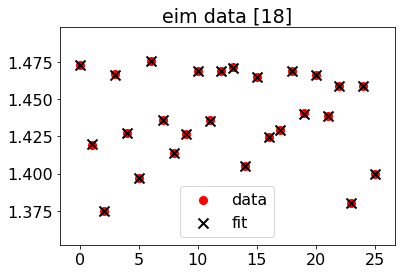

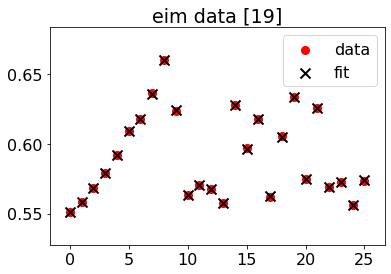

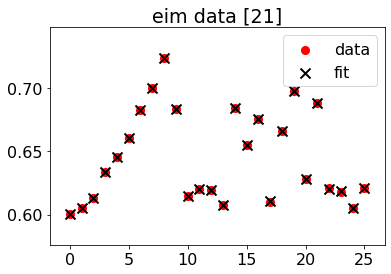

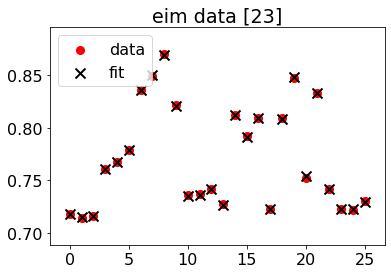

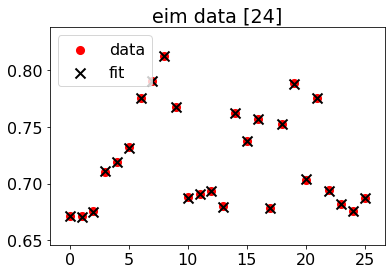

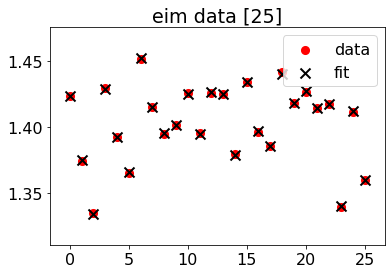

In [43]:
# fit_eim
X = sur.grb.greedy_points.copy()
X[:,0] = np.log(X[:,0])
y = sur.grb.eim.data
sur.fit_eim(X, y, method='lr', maxdegs=[4,4], max_deg_total=8)

In [44]:
for f in sur.fits:
    print(f.degrees)

[[0, 0], [1, 0], [2, 0], [3, 0], [0, 1], [1, 1], [2, 1], [0, 2], [1, 2], [0, 3]]
[[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1], [0, 2], [1, 2], [2, 2], [0, 3], [1, 3], [0, 4]]
[[0, 0], [1, 0], [0, 1], [1, 1], [0, 2], [1, 2], [0, 3], [1, 3], [0, 4]]
[[0, 0], [1, 0], [2, 0], [3, 0], [0, 1], [1, 1], [2, 1], [0, 2], [1, 2], [0, 3]]
[[0, 0], [1, 0], [2, 0], [3, 0], [0, 1], [1, 1], [2, 1], [0, 2], [1, 2], [0, 3]]
[[0, 0], [1, 0], [2, 0], [3, 0], [0, 1], [1, 1], [2, 1], [0, 2], [1, 2], [0, 3]]
[[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1], [0, 2], [1, 2], [0, 3]]
[[0, 0], [1, 0], [2, 0], [3, 0], [0, 1], [1, 1], [2, 1], [0, 2], [1, 2], [0, 3]]
[[0, 0], [1, 0], [2, 0], [3, 0], [0, 1], [1, 1], [2, 1], [0, 2], [1, 2], [0, 3]]
[[0, 0], [1, 0], [0, 1], [1, 1], [0, 2], [1, 2], [0, 3], [1, 3], [0, 4]]
[[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1], [0, 2], [1, 2], [2, 2], [0, 3], [1, 3], [0, 4]]
[[0, 0], [1, 0], [2, 0], [3, 0], [0, 1], [1, 1], [2, 1], [0, 2], [1, 2], [0, 3]]
[[0, 0], [1, 0], [2,

In [45]:
model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
print(f"worst case = {worst_case}")

worst case = [ 1.06038038 -0.09735096]


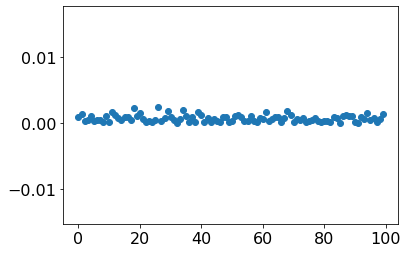

In [46]:
plt.figure()
plt.scatter(range(len(model_errors)), model_errors)
# plt.scatter(range(len(sur.grb.greedy_points)), np.zeros(len(sur.grb.greedy_points)))
plt.show()
plt.close()

In [47]:
plt.figure()
plt.plot(seed_x, vts[worst_error_index])
plt.plot(seed_x, sur.predict([worst_case]), ls='--')
plt.xlim(-300,100)
plt.yscale('log')

In [48]:
plt.figure()
plt.plot(seed_x, vts[worst_error_index] - sur.predict([worst_case]))

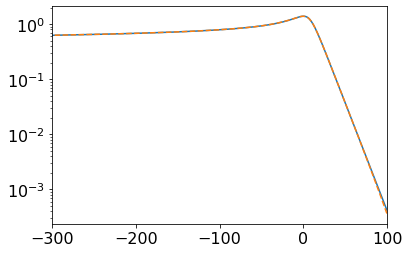

In [49]:
plt.figure()
plt.plot(seed_x, vts[6])
plt.plot(seed_x, sur.predict([vts_coords[6]]), ls='--')
plt.xlim(-300,100)
plt.yscale('log')

In [50]:
vts_coords.shape

(100, 2)

In [51]:
vts.shape

(100, 1000)

vts_coords_worst = [ 1.62253361 -0.33830412]
step = 0, error = 1.1530132092396684e-09


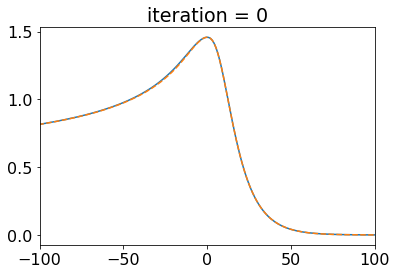

vts_coords_worst = [ 1.49395918 -0.02665469]
step = 0, error = 2.956329411196092e-09


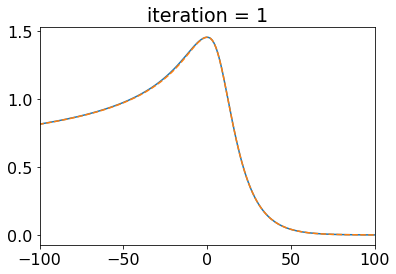

vts_coords_worst = [ 1.38980639 -0.41529222]
step = 0, error = 3.0387572328634956e-09


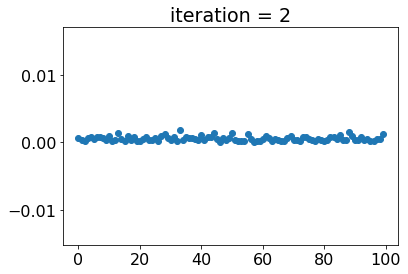

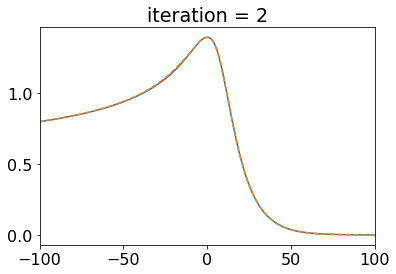

vts_coords_worst = [ 3.30857884 -0.4330141 ]
step = 0, error = 6.062180744110896e-10


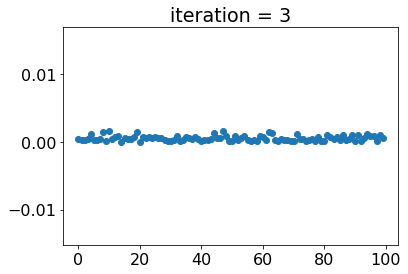

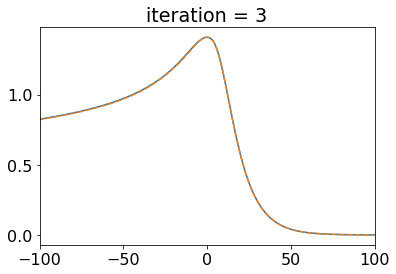

vts_coords_worst = [ 1.08295317 -0.06933487]
step = 0, error = 1.6801507303841776e-09


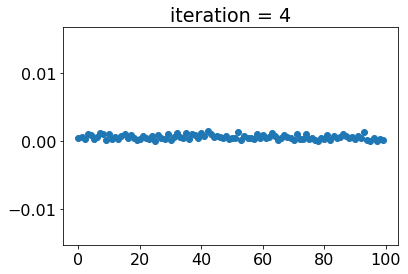

In [52]:
for i in range(5):

    _, vts, _, vts_coords = gen_2d_massratio_chi_data(
        np.random.uniform(qmin, qmax, 100),
        np.random.uniform(chimin, chimax, 100),
        mtotal)
    
    model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
    
    vts_worst = vts[worst_error_index]
    vts_coords_worst = vts_coords[worst_error_index]    
    print(f"vts_coords_worst = {vts_coords_worst}")
    
    # add the worst case to the basis and re-fit
    sur.run_greedy_sweep(vts_worst.reshape(1,-1), vts_coords_worst.reshape(1, -1), greedy_tol=1e-12)
    
    # build eim
    # eim needs to be built from training_set at the greedy points
    _, ts, _, _ = gen_2d_massratio_chi_data(*sur.grb.greedy_points.T, mtotal)
    
    sur.build_eim(ts) 
    
    # fit_eim
    
    X = sur.grb.greedy_points.copy()
    X[:,0] = np.log(X[:,0])
    y = sur.grb.eim.data
    sur.fit_eim(X, y, method='lr', maxdegs=[4,4], max_deg_total=4*2, verbose=False)
    
    model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
    
    plt.figure()
    plt.title(f"iteration = {i}")
    plt.scatter(range(len(model_errors)), model_errors)
    # plt.scatter(range(len(sur.grb.greedy_points)), np.zeros(len(sur.grb.greedy_points)))
    plt.show()
    plt.close()
    
    plt.figure()
    plt.title(f"iteration = {i}")
    plt.plot(seed_x, vts[worst_error_index])
    plt.plot(seed_x, sur.predict([worst_case]), ls='--')
    plt.xlim(-100,100)
    plt.show()
    plt.close()